In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy

3. Sampling rate

In [3]:
data_folder = './data/'

csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

sampling_frequencies = {}

for file in csv_files:
    filepath = os.path.join(data_folder, file)
    df = pd.read_csv(filepath, header=None)  
    time = df.iloc[:, 0].values

    num_samples = len(time)
    total_time = time[-1] - time[0]
    sampling_frequency = num_samples / total_time

    sampling_frequencies[file] = sampling_frequency

    print(f"{file}: {sampling_frequency:.2f} Hz")


sigA.csv: 10000.20 Hz
sigB.csv: 3300.20 Hz
sigC.csv: 2500.13 Hz
sigD.csv: 400.08 Hz


4. Fourier transforms

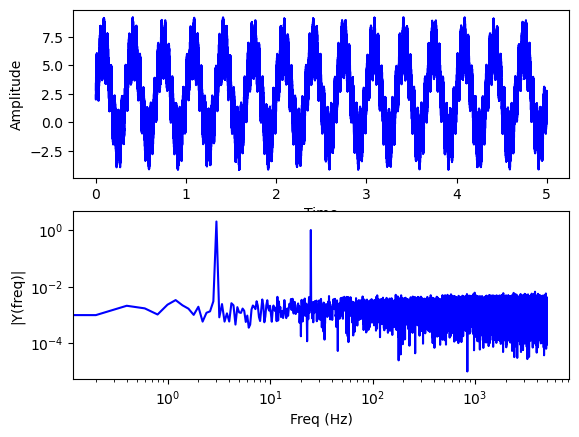

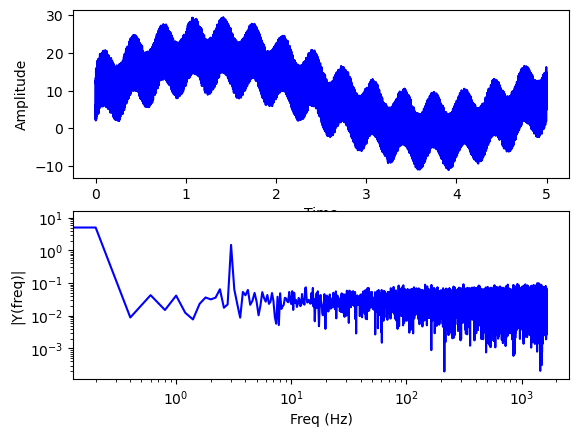

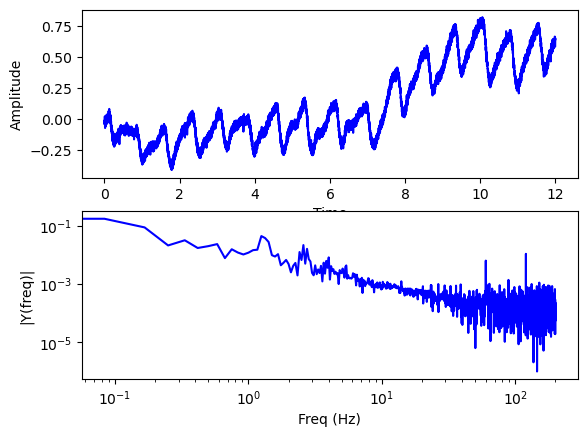

In [4]:
def plot_time_and_fft(file):
    df = pd.read_csv(f'data/{file}', header=None)
    time = df[0].values
    signal = df[1].values
    
    Fs = sampling_frequencies[file]  
    n = len(signal)               
    T = n/Fs                       
    
    k = np.arange(n)
    frq = k/T 
    frq = frq[range(int(n/2))]    
    Y = np.fft.fft(signal)/n       
    Y = Y[range(int(n/2))]

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(time,signal,'b')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax2.loglog(frq,abs(Y),'b') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    plt.show()

# Analyze target files
for file in ['sigA.csv', 'sigB.csv', 'sigD.csv']:
    plot_time_and_fft(file)


5. Moving Average Filter

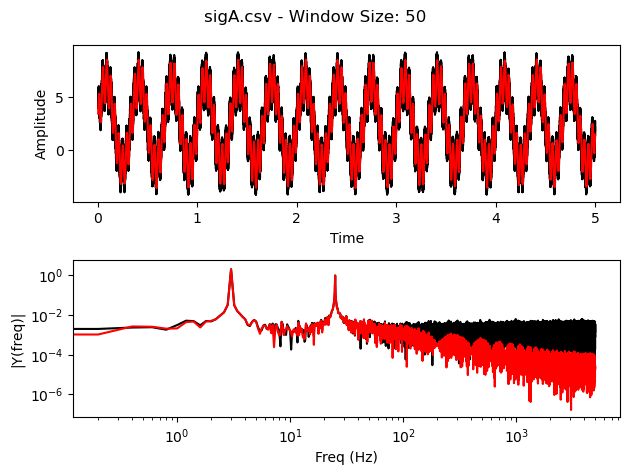

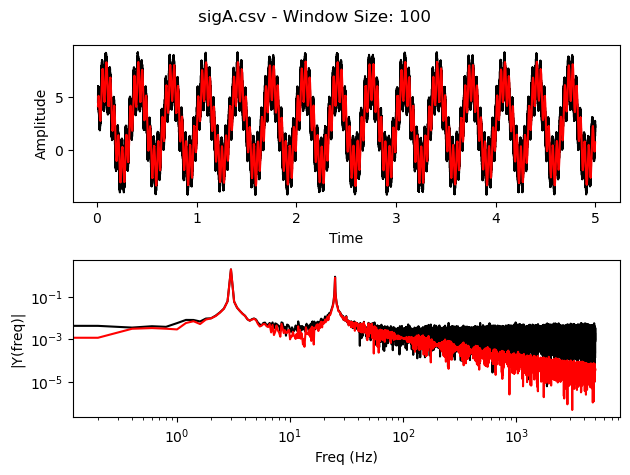

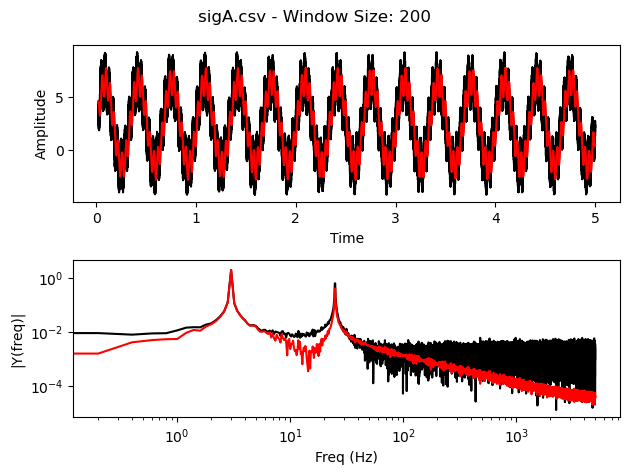

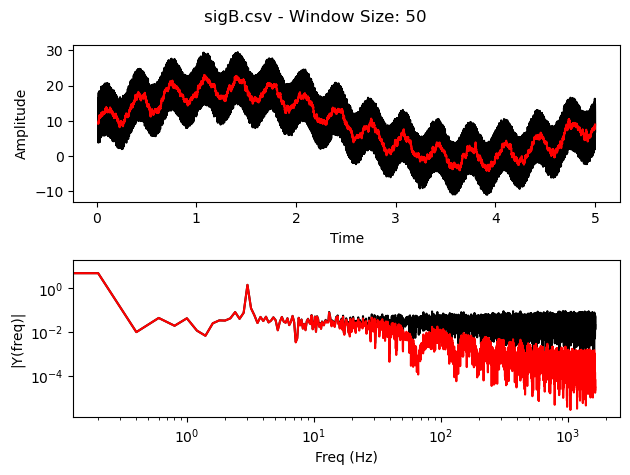

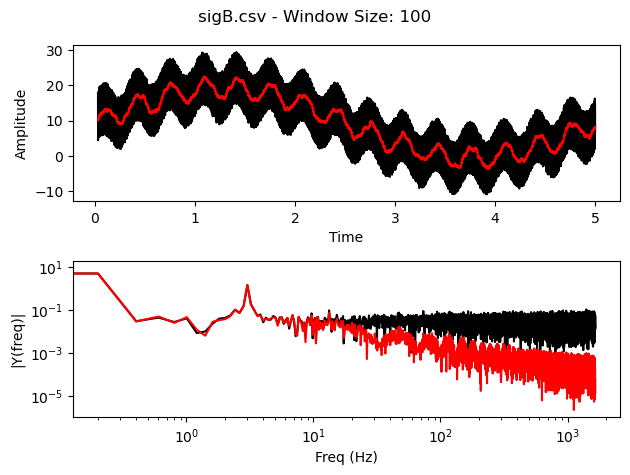

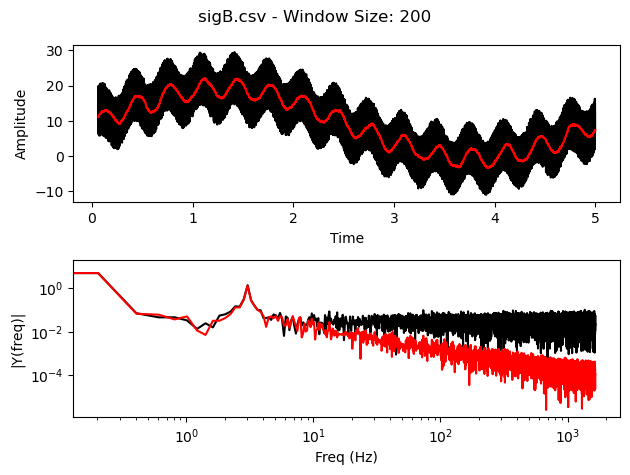

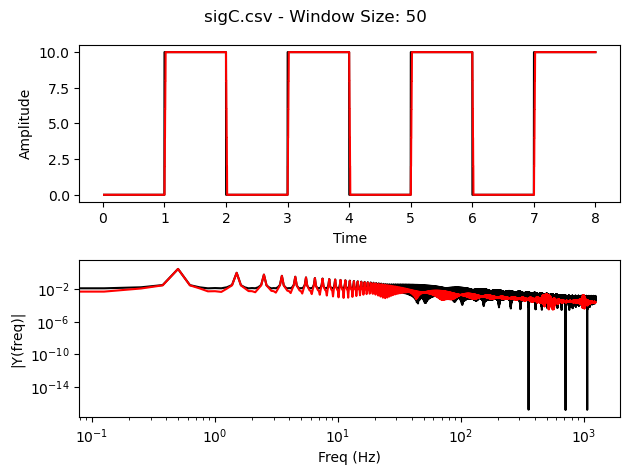

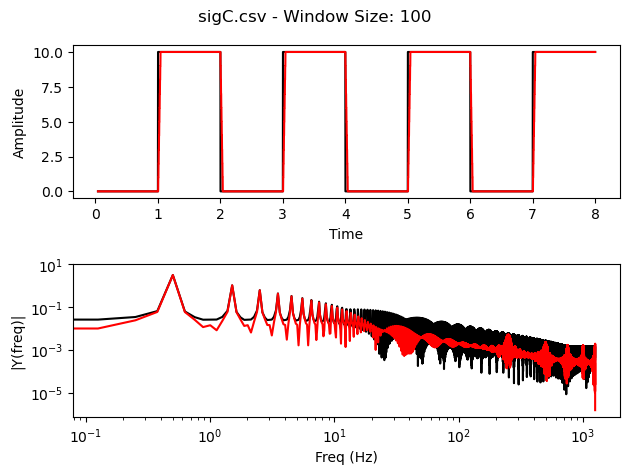

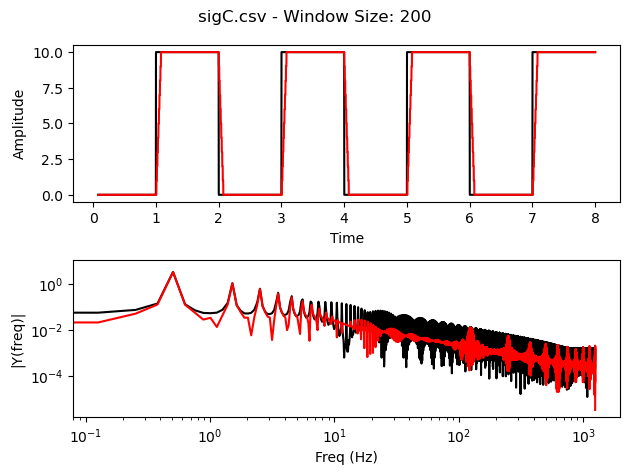

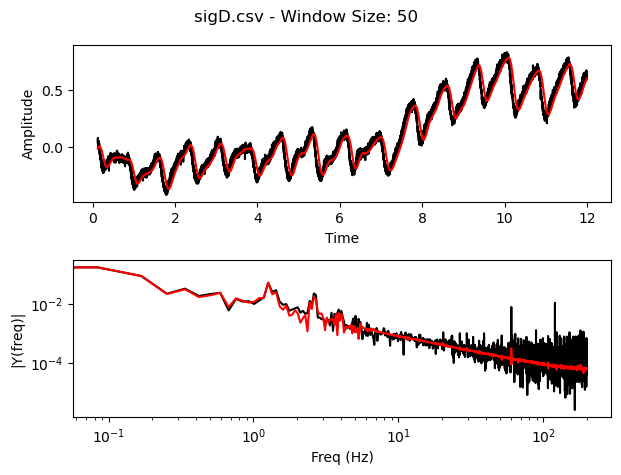

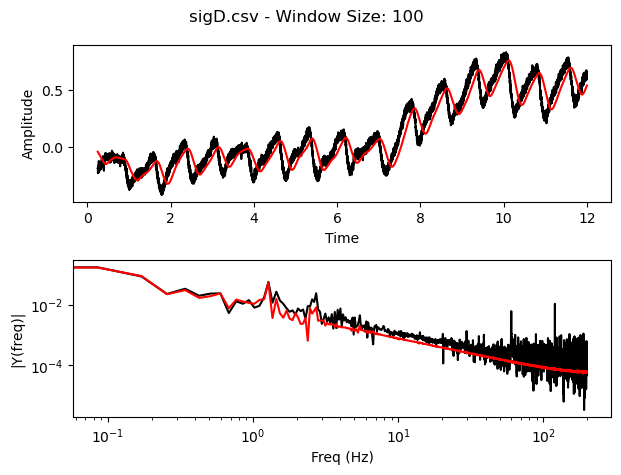

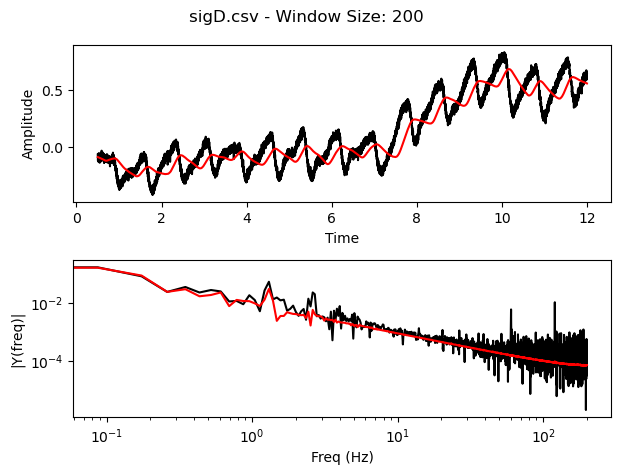

In [ ]:
def moving_average(signal, window_size):
    filtered = np.zeros_like(signal[window_size:])
    for i in range(window_size, len(signal)):
        filtered[i-window_size] = np.mean(signal[i - window_size:i])
    return filtered


def compute_fft(signal, Fs):
    n = len(signal)               
    T = n/Fs                       
    k = np.arange(n)
    frq = k/T 
    frq = frq[range(int(n/2))]    
    Y = np.fft.fft(signal)/n       
    Y = Y[range(int(n/2))]
    return frq, np.abs(Y)

files = ['sigA.csv', 'sigB.csv','sigC.csv', 'sigD.csv']
window_sizes = [50, 100, 200] 

for file in files:
    df = pd.read_csv(f'data/{file}', header=None)
    time = df[0].values
    signal = df[1].values
    Fs = sampling_frequencies[file]  
    
    for ws in window_sizes:
        filtered = moving_average(signal, ws)
        
        # Compute FFTs
        f_orig, mag_orig = compute_fft(signal[ws:], Fs)
        f_filt, mag_filt = compute_fft(filtered, Fs)

        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1)
        
        # Time domain plot
        ax1.plot(time[ws:], signal[ws:], 'k')
        ax1.plot(time[ws:], filtered, 'r')
        ax1.set(xlabel='Time', ylabel='Amplitude')

        
        # Frequency domain plot
        ax2.loglog(f_orig, mag_orig, 'k')
        ax2.loglog(f_filt, mag_filt, 'r')
        ax2.set_xlabel('Freq (Hz)')
        ax2.set_ylabel('|Y(freq)|')
        
        plt.suptitle(f'{file} - Window Size: {ws}')
        plt.tight_layout()
        plt.show()


6. IIR

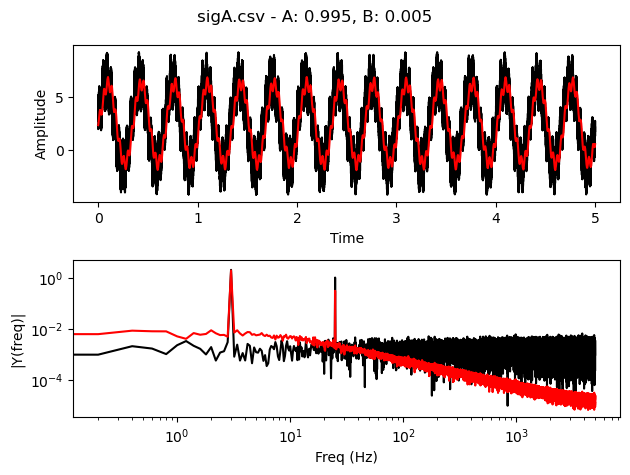

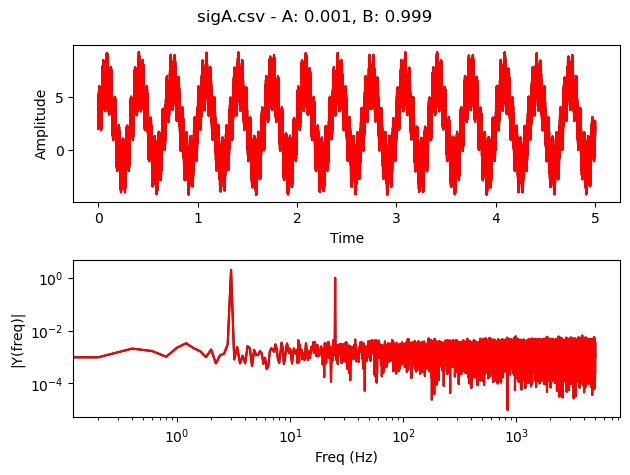

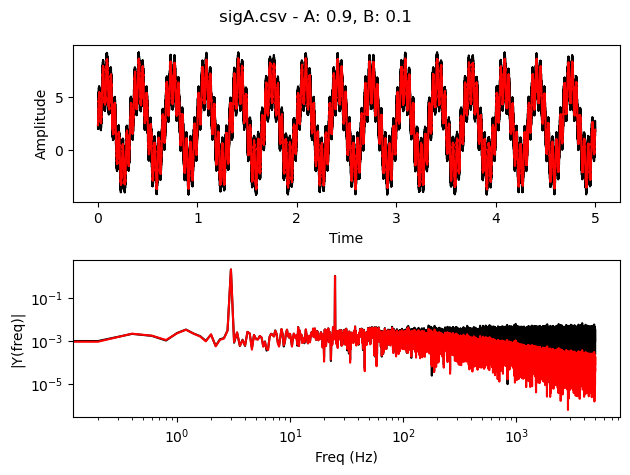

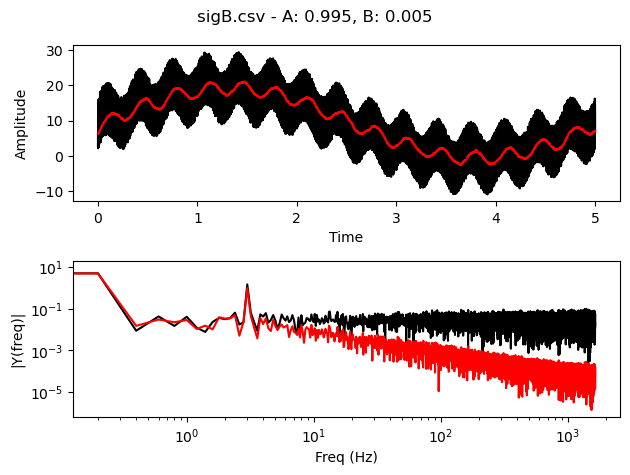

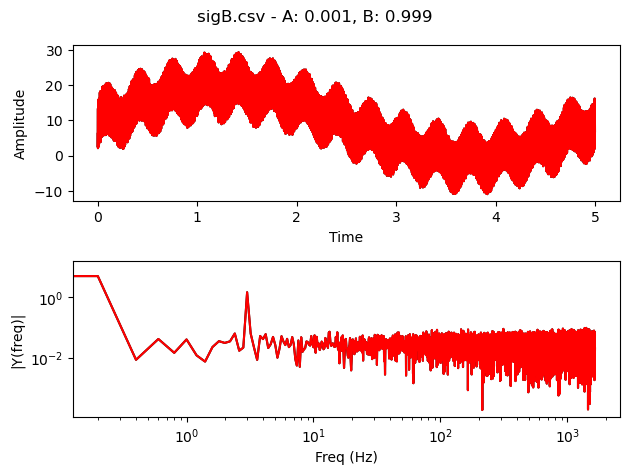

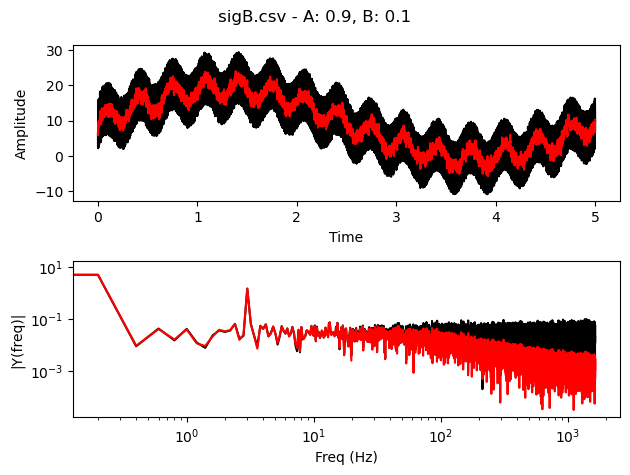

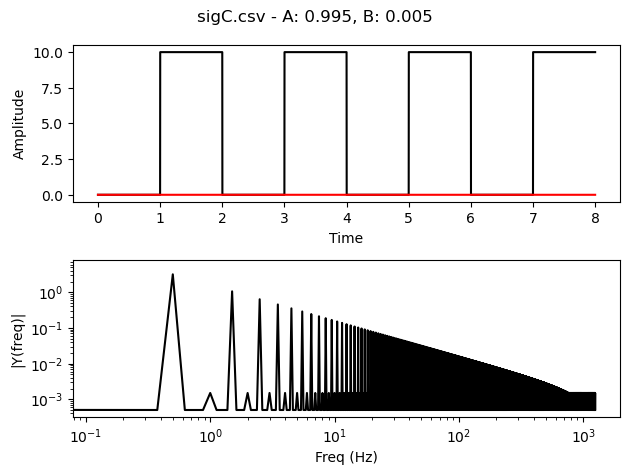

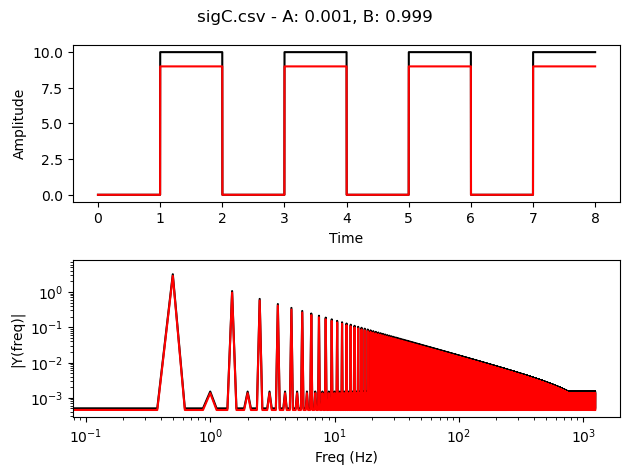

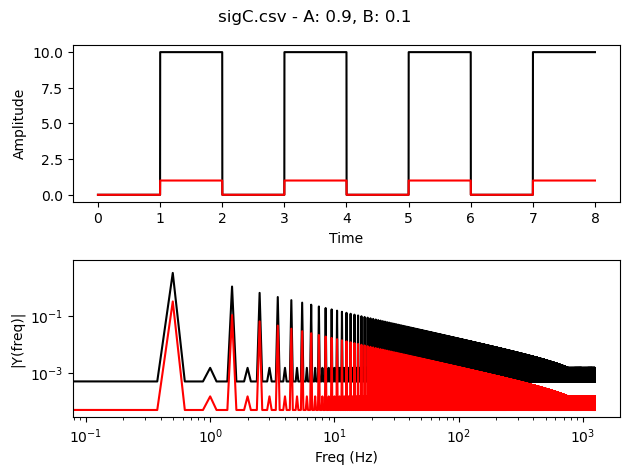

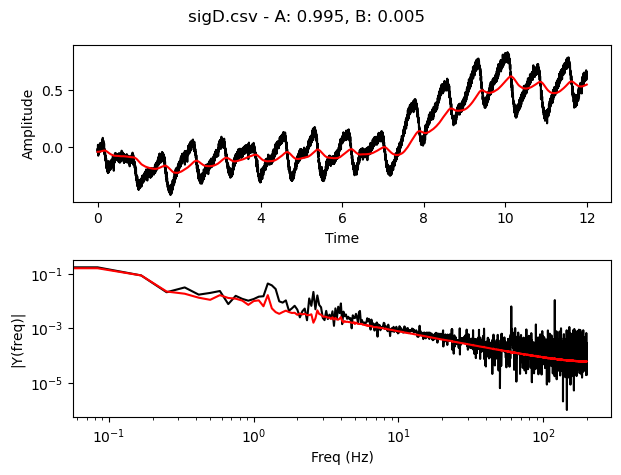

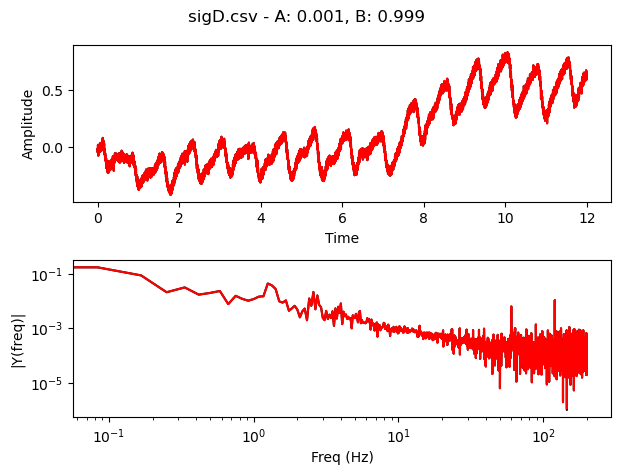

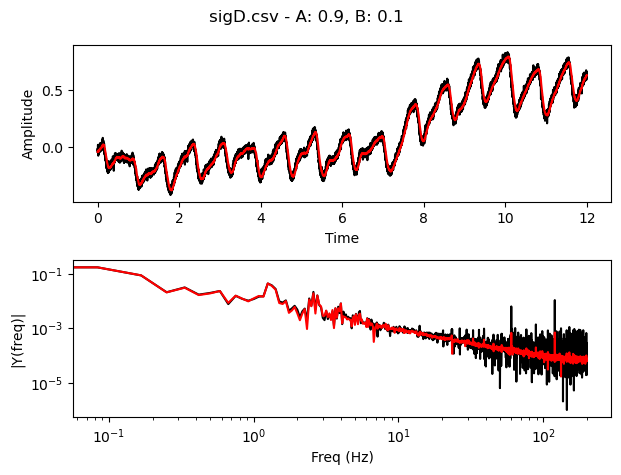

In [41]:
def iir(signal, A, B):
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = A * filtered[i-1] + B * signal[i]
    return filtered

files = ['sigA.csv', 'sigB.csv','sigC.csv', 'sigD.csv']
ab_pairs = [(0.995, 0.005), (0.001, 0.999), (0.9, 0.1)]

for file in files:
    df = pd.read_csv(f'data/{file}', header=None)
    time = df[0].values
    signal = df[1].values
    Fs = sampling_frequencies[file]  
    
    for A, B in ab_pairs:
        filtered = iir(signal, A, B)
        
        # Compute FFTs
        f_orig, mag_orig = compute_fft(signal, Fs)
        f_filt, mag_filt = compute_fft(filtered, Fs)

        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1)
        
        # Time domain plot
        ax1.plot(time, signal, 'k')
        ax1.plot(time, filtered, 'r')
        ax1.set(xlabel='Time', ylabel='Amplitude')

        
        # Frequency domain plot
        ax2.loglog(f_orig, mag_orig, 'k')
        ax2.loglog(f_filt, mag_filt, 'r')
        ax2.set_xlabel('Freq (Hz)')
        ax2.set_ylabel('|Y(freq)|')
        
        plt.suptitle(f'{file} - A: {A}, B: {B}')
        plt.tight_layout()
        plt.show()


7. FIR

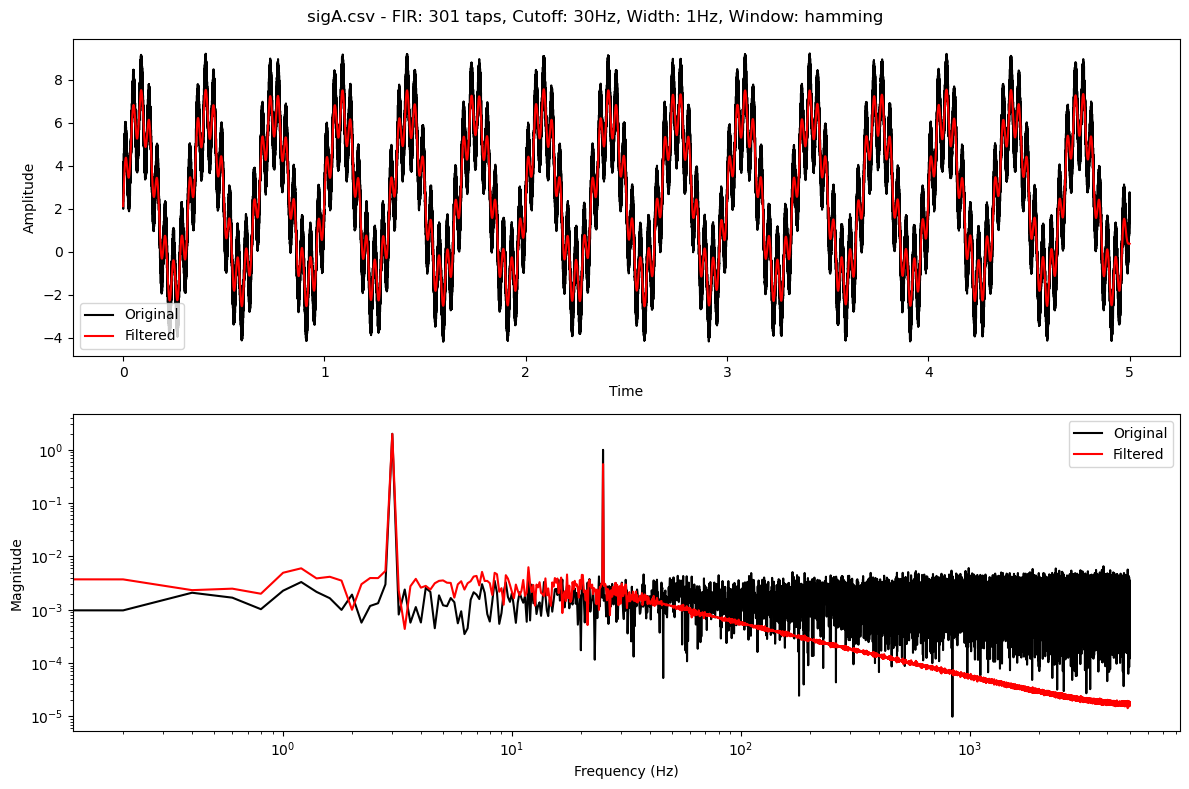

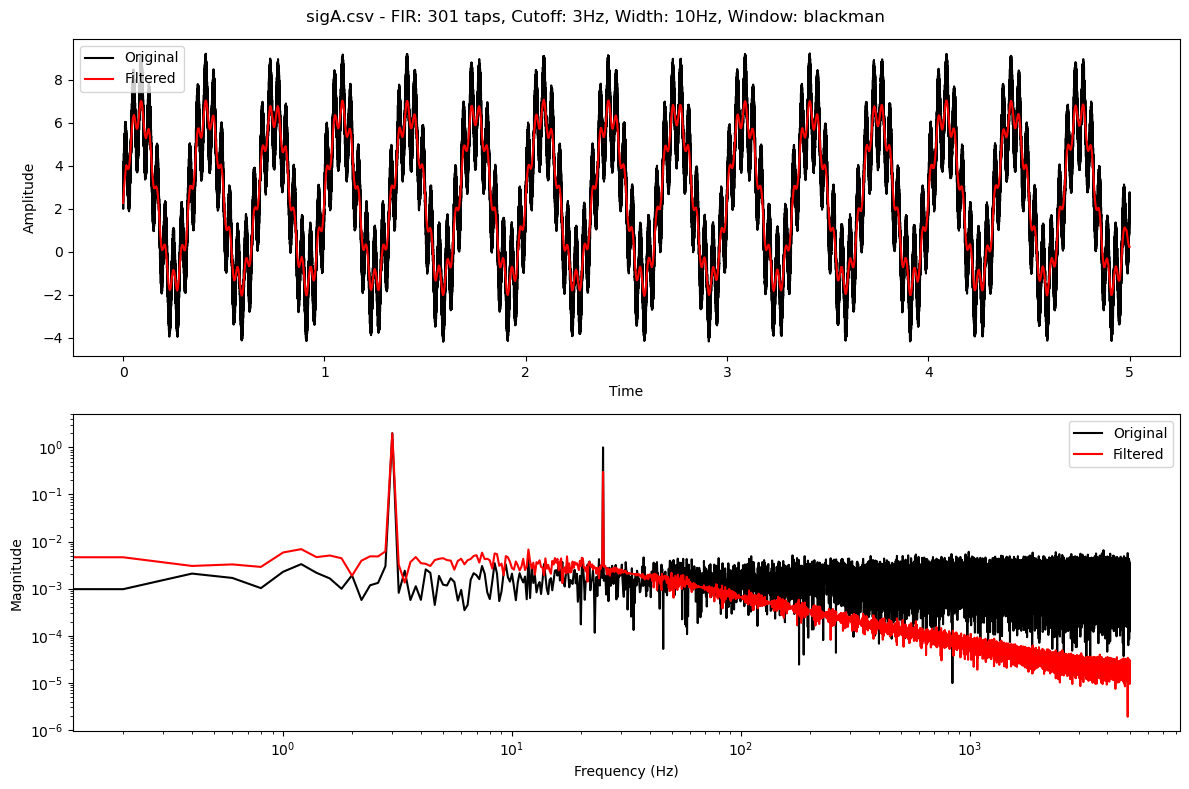

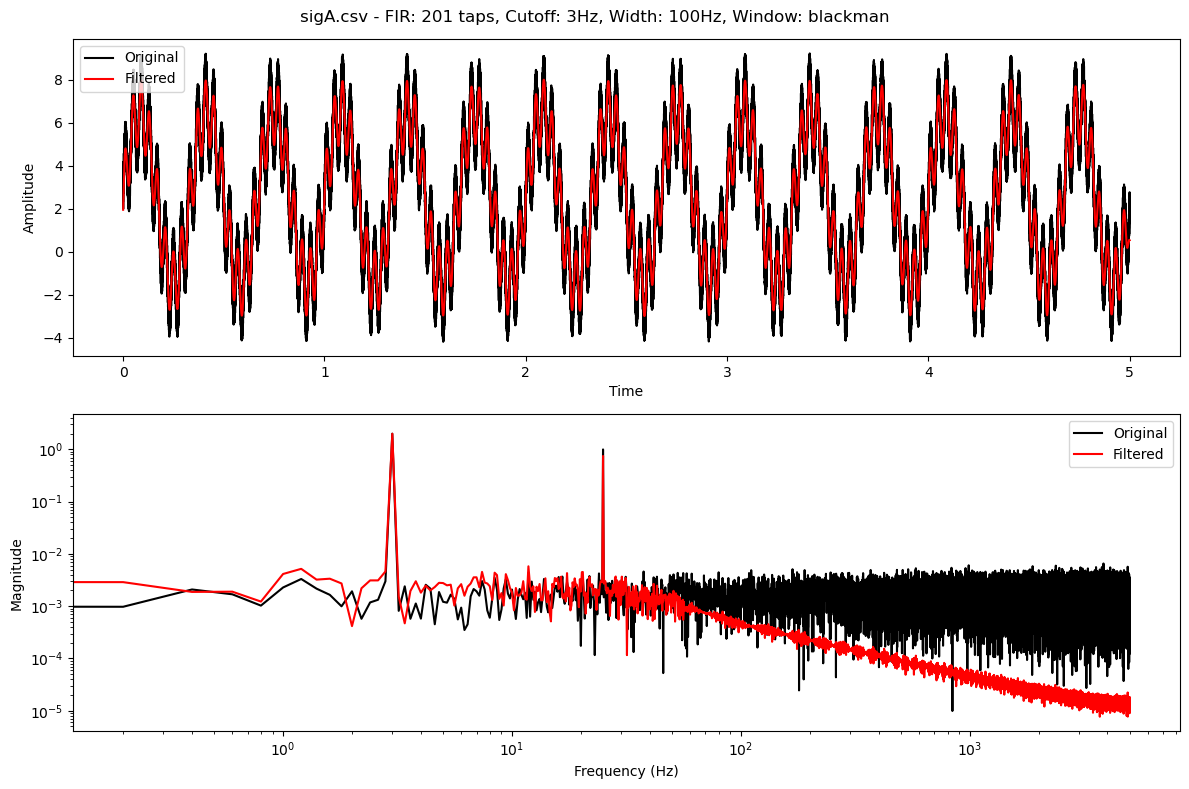

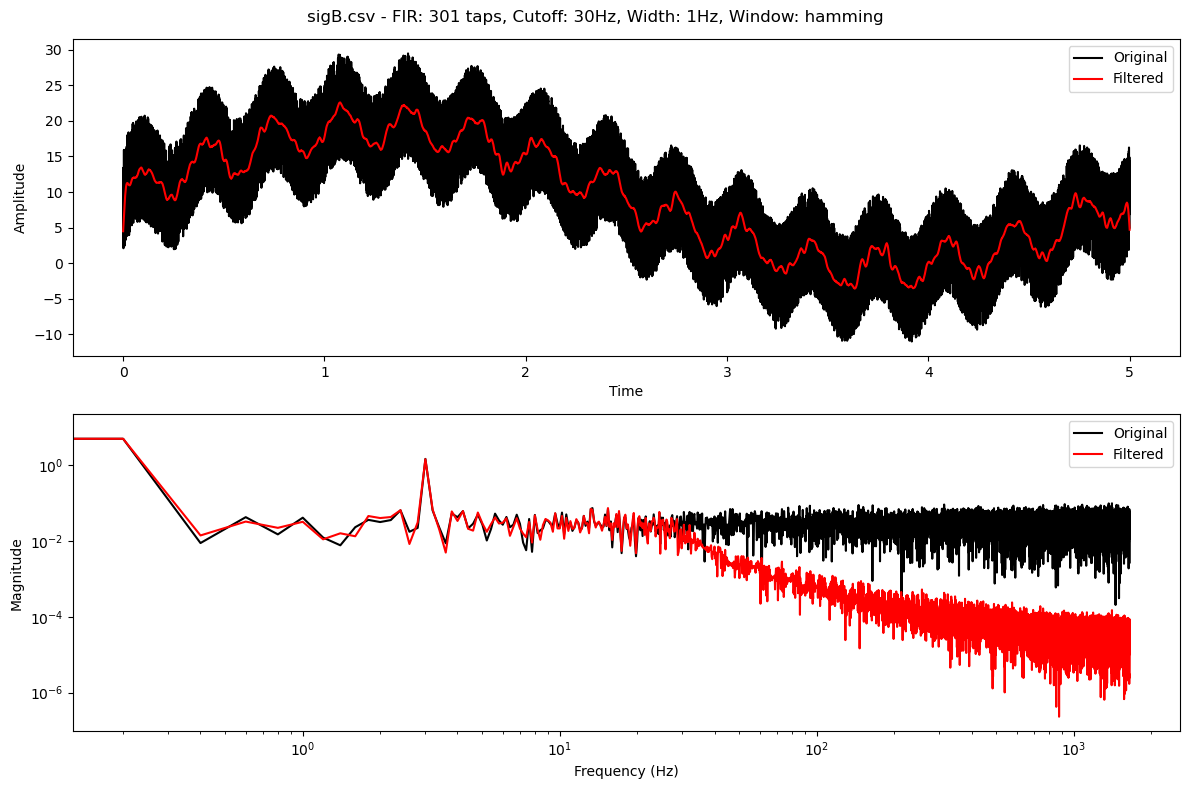

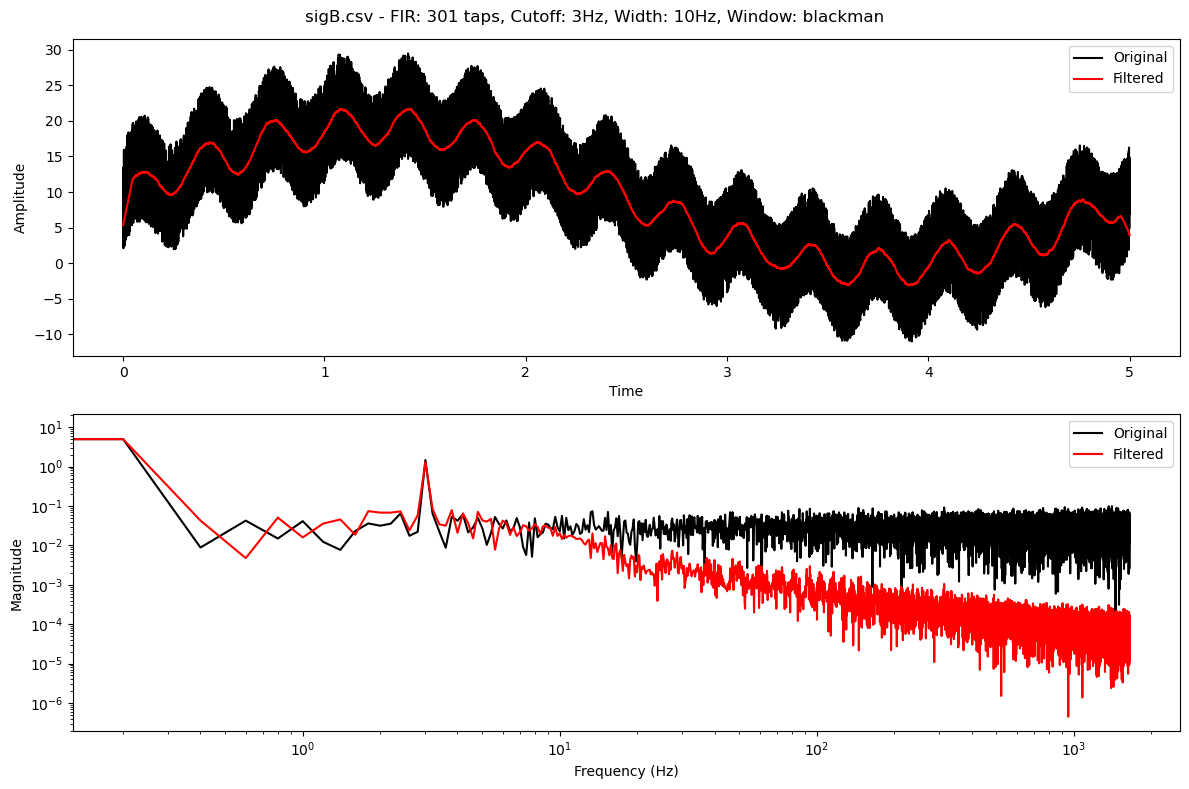

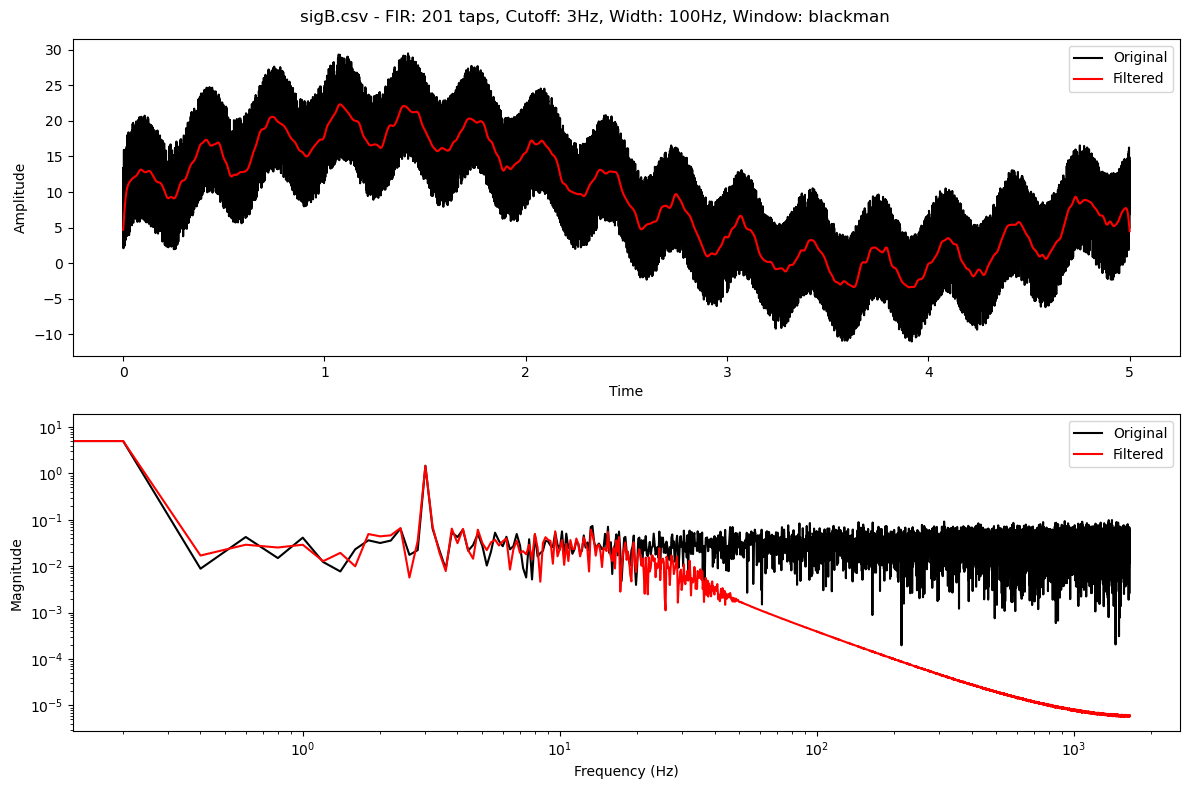

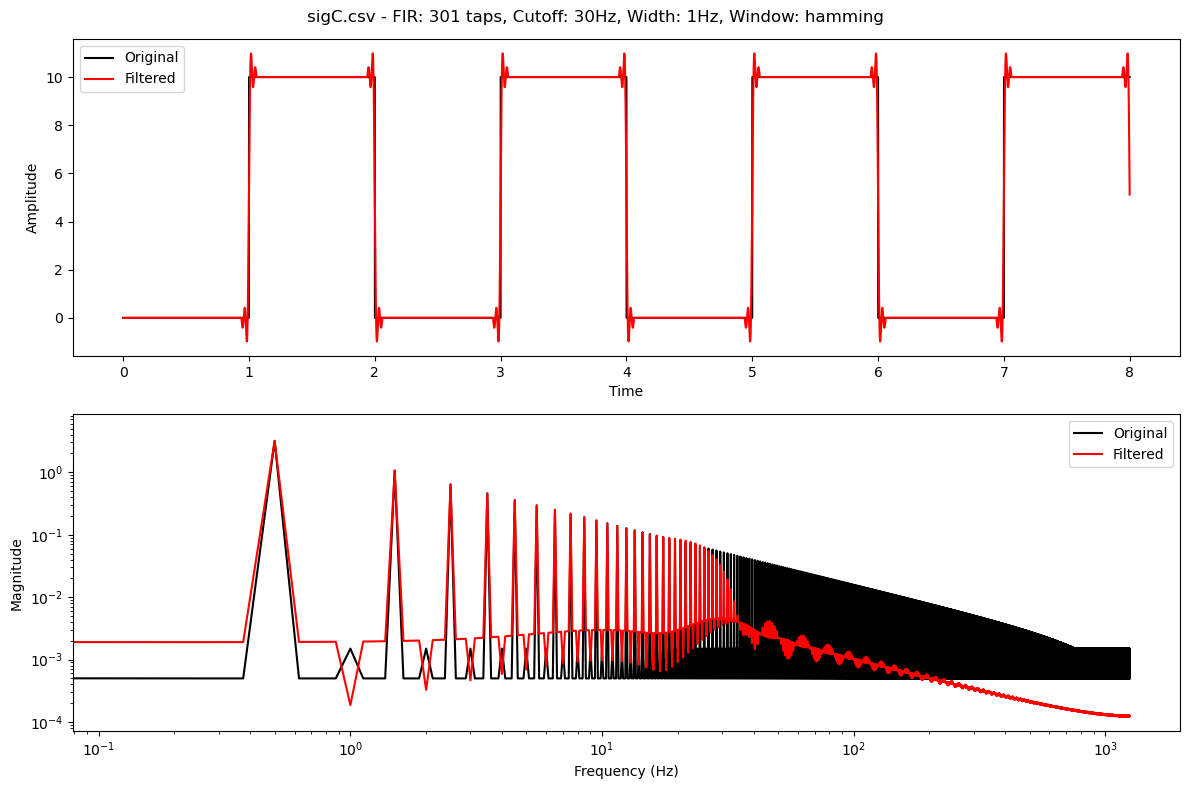

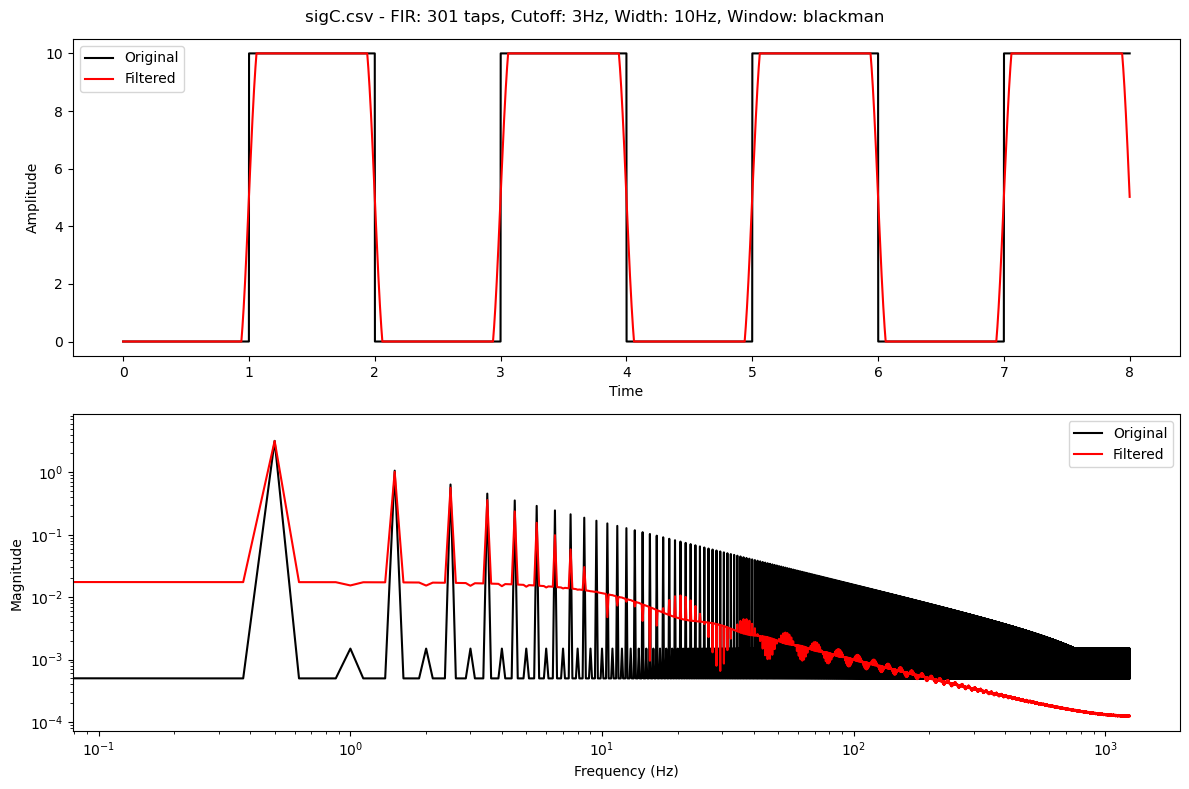

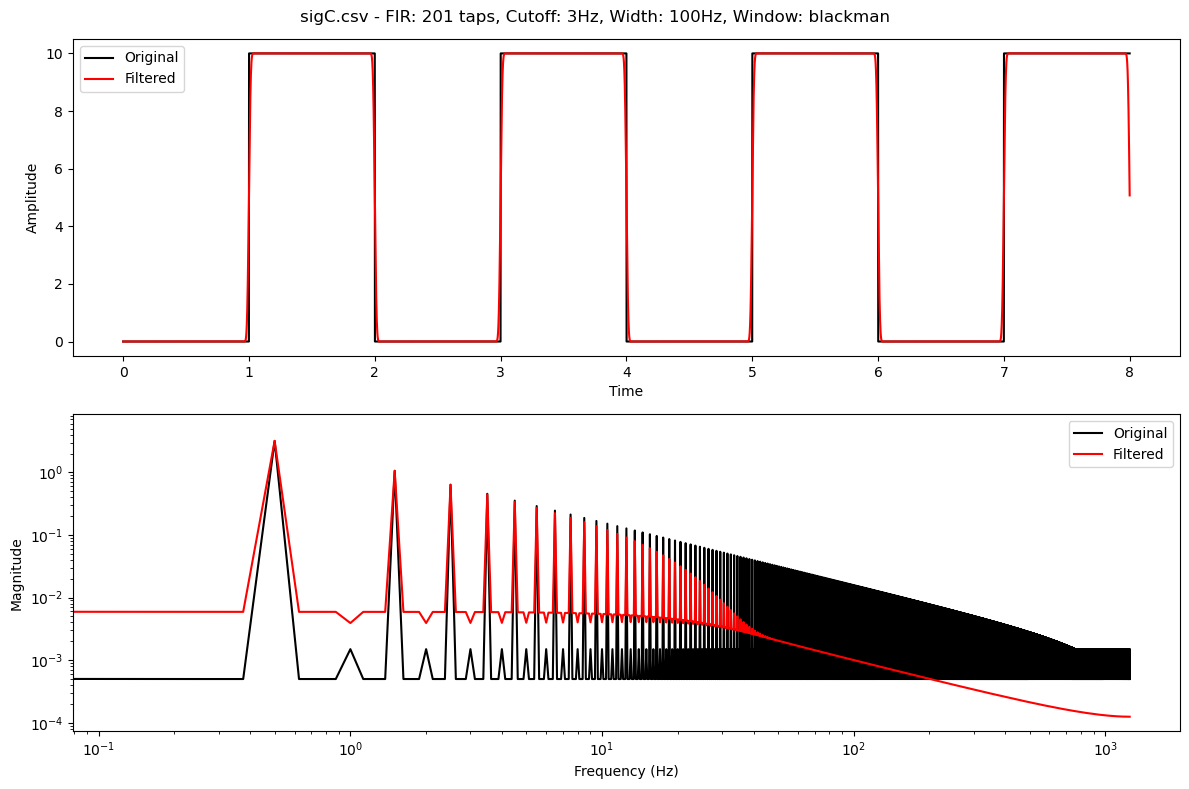

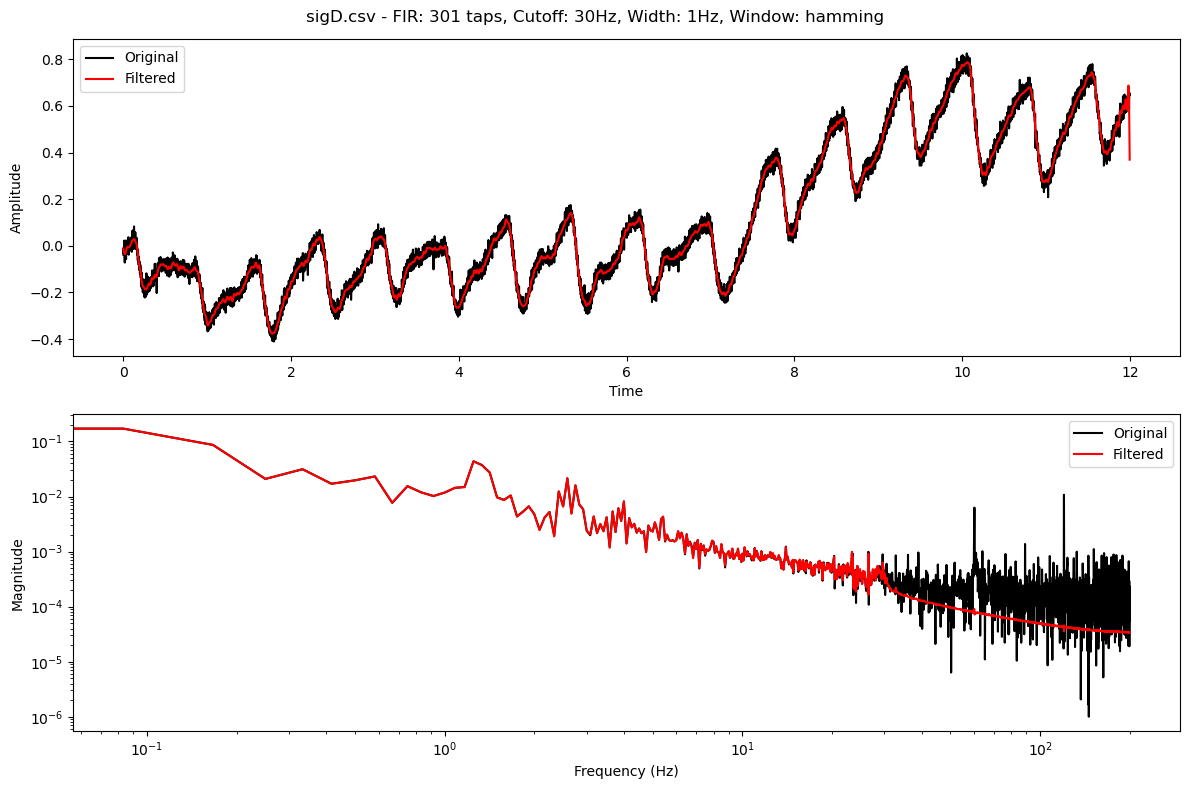

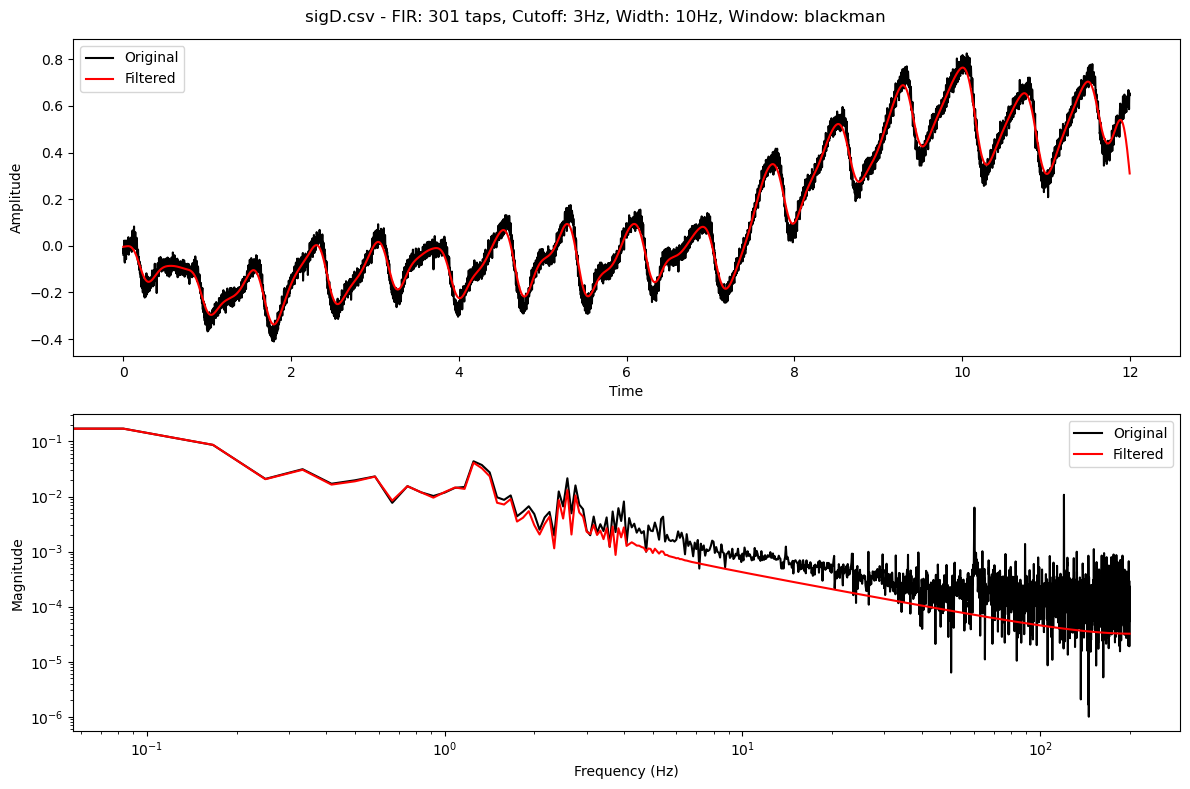

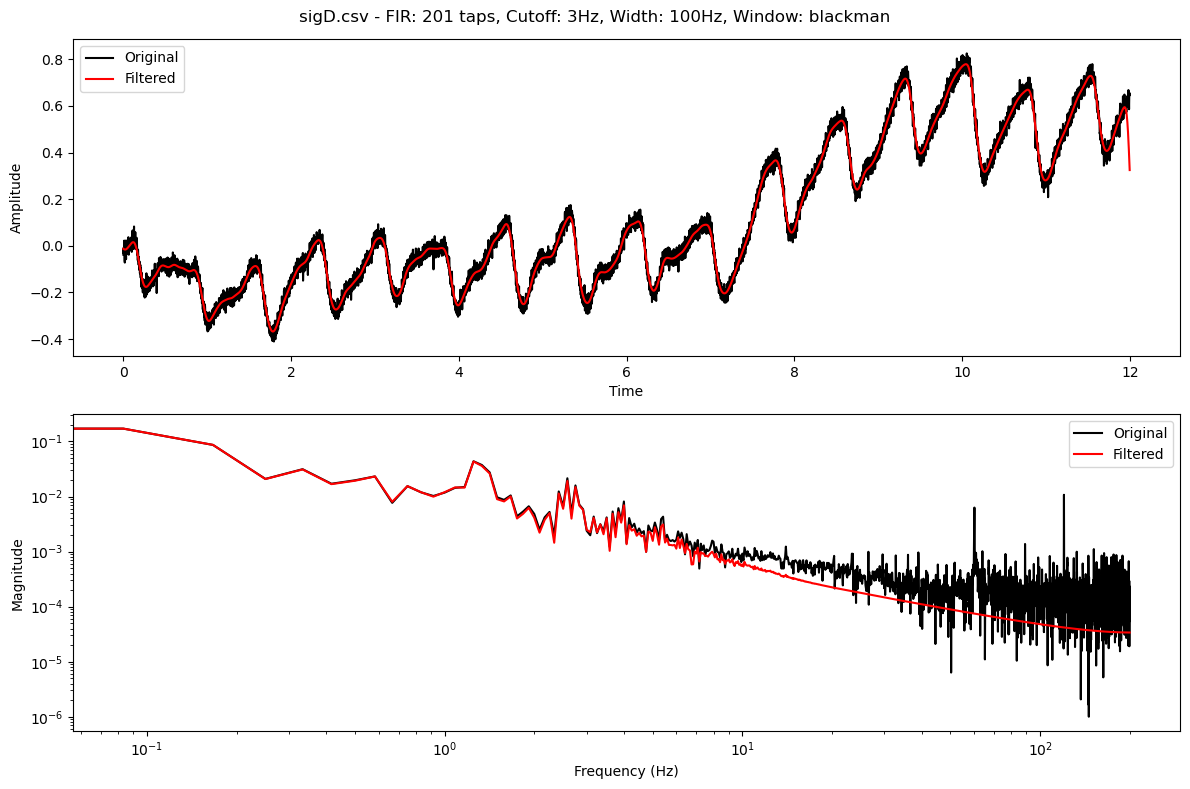

In [69]:
def design_fir_filter(numtaps, cutoff, width, window, fs):
    return scipy.signal.firwin(numtaps, cutoff, width=width, window=window, fs=fs)

def apply_fir(signal, coefficients):
    return scipy.signal.convolve(signal, coefficients, mode='same')

# Filter parameters
fir_configs = [
    {'numtaps': 301, 'cutoff': 30, 'width': 1, 'window': 'hamming'},
    {'numtaps': 301, 'cutoff': 3, 'width': 10, 'window': 'blackman'},
    {'numtaps': 201, 'cutoff': 3, 'width': 100, 'window': 'blackman'},
]

files = ['sigA.csv', 'sigB.csv', 'sigC.csv', 'sigD.csv']

for file in files:
    df = pd.read_csv(f'data/{file}', header=None)
    time = df[0].values
    signal = df[1].values
    Fs = sampling_frequencies[file]  
    
    for config in fir_configs:
        coeffs = design_fir_filter(
            config['numtaps'],
            config['cutoff'],
            config['width'],
            config['window'],
            fs=Fs
        )
        
        filtered = apply_fir(signal, coeffs)

        f_orig, mag_orig = compute_fft(signal, Fs)
        f_filt, mag_filt = compute_fft(filtered, Fs)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        ax1.plot(time, signal, 'k', label='Original')
        ax1.plot(time, filtered, 'r', label='Filtered')
        ax1.set(xlabel='Time', ylabel='Amplitude')
        ax1.legend()
        
        # Frequency domain plot
        ax2.loglog(f_orig, mag_orig, 'k', label='Original')
        ax2.loglog(f_filt, mag_filt, 'r', label='Filtered')
        ax2.set(xlabel='Frequency (Hz)', ylabel='Magnitude')
        ax2.legend()
        
        title_info = (
            f"{file} - FIR: {config['numtaps']} taps, "
            f"Cutoff: {config['cutoff']}Hz, "
            f"Width: {config['width']}Hz, "
            f"Window: {config['window']}"
        )
        plt.suptitle(title_info)
        plt.tight_layout()
        plt.show()
